In [1]:
%run ./utils.ipynb

In [3]:
sz = 128
max_crop_sz = int(sz * 0.9)

In [4]:
trn_tfms = albumentations.Compose([
    albumentations.HorizontalFlip(),
    albumentations.RandomSizedCrop((max_crop_sz, max_crop_sz), sz, sz, interpolation=1, p=0.5),
    albumentations.IAAAffine(rotate=10, p=0.5, mode='edge'),
    albumentations.Blur()
])

In [5]:
db = get_data_bunch(sz=sz, bs=40, part=0, trn_tfms=trn_tfms)

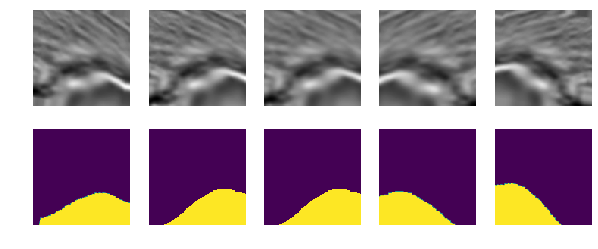

In [6]:
db.train_dl.dl.dataset.check_tfms(1)

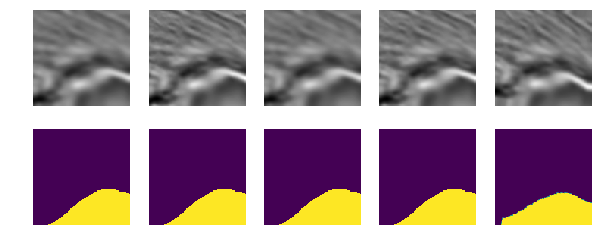

In [7]:
db.train_dl.dl.dataset.check_tfms(1)

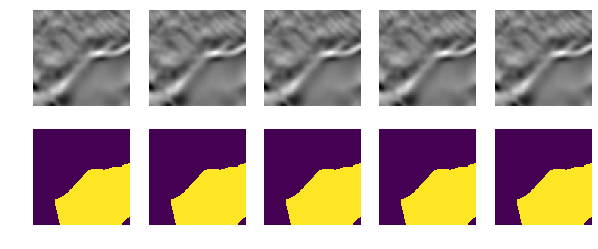

In [8]:
db.valid_dl.dl.dataset.check_tfms(15)

In [9]:
# Hyperparameters
mult = 2 # channel multiplier for transposed convolutions
k = 4 # kernel size of transposed convolutions, needs to be a multiple of 2
folds_to_train = range(n_splits)

In [10]:
def get_learner(db):
    res34 = pretrainedmodels.resnet34()
    base = nn.Sequential(*list(res34.children())[:-2])
    m = Unet34Like(base)
    m.cuda(default_device);
    learn = Learner(db, m, true_wd=True, loss_fn=bce_loss, layer_groups=split_model_idx(m, [61, 91]), opt_fn=lambda x: optim.SGD(x))
#     learn = Learner(db, m, true_wd=True, loss_fn=loss, layer_groups=split_model_idx(m, [61, 91]), opt_fn=AdamW)
    learn.metrics = [accuracy_thresh, dice, iou_pytorch]
    learn.callbacks = [SaveBest()]
    return learn

In [11]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, k, stride=2, padding=(k-2)//2)
        self.bn = nn.BatchNorm2d(n_out)
        self.out_channels = n_out
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    
class Unet34Like(nn.Module):        
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,192 * mult)
        self.up2 = UnetBlock(192 * mult,128,96 * mult)
        self.up3 = UnetBlock(96 * mult,64,32 * mult)
        self.up4 = UnetBlock(32 * mult,64,32 * mult)
        self.up5 = UnetBlock(32 * mult,3,16 * mult)
        
        self.se1 = scSELayer(self.up1.out_channels)
        self.se2 = scSELayer(self.up2.out_channels)
        self.se3 = scSELayer(self.up3.out_channels)
        self.se4 = scSELayer(self.up4.out_channels)
        self.se5 = scSELayer(self.up5.out_channels)
        
        self.se_feat0 = scSELayer(64)
        self.se_feat1 = scSELayer(64)
        self.se_feat2 = scSELayer(128)
        self.se_feat3 = scSELayer(256)
        
        self.hc1 = HCBlock(self.up1.out_channels, out_sz=sz)
        self.hc2 = HCBlock(self.up2.out_channels, out_sz=sz)
        self.hc3 = HCBlock(self.up3.out_channels, out_sz=sz)
        self.hc4 = HCBlock(self.up4.out_channels, out_sz=sz)
        
        self.hc_comb = nn.Conv2d(64, 8, 3, padding=1)
        self.hc_bn = nn.BatchNorm2d(8)
        
        self.up6 = nn.ConvTranspose2d(16 * mult + 8, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.se_feat3(self.sfs[3].features))
        x = self.se1(x)
        hc1 = self.hc1(x)
        
        x = self.up2(x, self.se_feat2(self.sfs[2].features))
        x = self.se2(x)
        hc2 = self.hc2(x)
        
        x = self.up3(x, self.se_feat1(self.sfs[1].features))
        x = self.se3(x)
        hc3 = self.hc3(x)
        
        x = self.up4(x, self.se_feat0(self.sfs[0].features))
        x = self.se4(x)
        hc4 = self.hc4(x)
        
        x = self.up5(x, inp)
        x = self.se5(x)
        
        hc = self.hc_comb(torch.cat((hc1, hc2, hc3, hc4), dim=1))
        hc = self.hc_bn(F.relu(hc))
        x = torch.cat((x, hc), dim=1)
        x = self.up6(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [12]:
name = 'unet34_like_128'

In [13]:
%%time
for fold in folds_to_train:
    print(f'### Starting to train fold {fold} ###')
    db = get_data_bunch(sz=sz, bs=40, part=fold, trn_tfms=trn_tfms)
    learn = get_learner(db)
    learn.freeze_to(2)
    learn.fit_one_cycle(3, 1e-1)
    learn.freeze_to(1)
    learn.fit_one_cycle(6, 1e-1)
    learn.unfreeze()
    learn.fit_one_cycle(40, 5e-2)
    learn.loss_fn = lovasz_loss
    learn.fit_one_cycle(40, 1e-2)
    learn.save(f'{name}_fold{fold}')

### Starting to train fold 0 ###
epoch  train loss  valid loss  accuracy_thresh  dice  iou_pytorch
0      0.314827    0.248732    0.901192         0.775858  0.503301   
1      0.237038    0.208385    0.918953         0.827536  0.607457   
2      0.203817    0.200963    0.923108         0.840566  0.652812   
epoch  train loss  valid loss  accuracy_thresh  dice  iou_pytorch
0      0.207558    0.226895    0.908953         0.811151  0.626650   
1      0.199225    0.192868    0.926818         0.842254  0.717726   
2      0.188794    0.165899    0.934573         0.864153  0.730685   
3      0.173515    0.178029    0.932602         0.857842  0.714181   
4      0.150899    0.168881    0.935940         0.866884  0.737286   
5      0.139863    0.164505    0.937749         0.873582  0.737164   
epoch  train loss  valid loss  accuracy_thresh  dice  iou_pytorch
0      0.145907    0.171085    0.936251         0.871200  0.743398   
1      0.146942    0.186049    0.930396         0.858665  0.708435   

12     0.144041    0.139445    0.945331         0.881383  0.734938   
13     0.144344    0.133056    0.946507         0.882421  0.742593   
14     0.143489    0.153933    0.942901         0.873260  0.734938   
15     0.148451    0.150394    0.940316         0.870786  0.727531   
16     0.134270    0.163511    0.938065         0.862691  0.722963   
17     0.135909    0.161829    0.940659         0.878084  0.738148   
18     0.141558    0.199371    0.923027         0.827104  0.706420   
19     0.137271    0.170128    0.931034         0.855360  0.715309   
20     0.132396    0.164149    0.941846         0.875401  0.736420   
21     0.132265    0.149165    0.943260         0.878318  0.735309   
22     0.131442    0.149612    0.944103         0.877494  0.736173   
23     0.136663    0.156549    0.937630         0.863649  0.718272   
24     0.126977    0.147160    0.943615         0.877254  0.713704   
25     0.126004    0.151340    0.935135         0.867575  0.727037   
26     0.116920    0

36     0.064096    0.150230    0.956858         0.909764  0.758794   
37     0.061891    0.146265    0.956533         0.909696  0.764573   
38     0.059656    0.139431    0.957037         0.910473  0.766709   
39     0.067328    0.145628    0.956884         0.909932  0.766583   
epoch  train loss  valid loss  accuracy_thresh  dice  iou_pytorch
0      0.345981    0.554776    0.956114         0.907508  0.758794   
1      0.349398    0.533846    0.956481         0.908599  0.760930   
2      0.316127    0.491524    0.961718         0.920546  0.776005   
3      0.291638    0.500961    0.951104         0.898893  0.759422   
4      0.313794    0.441107    0.954698         0.909430  0.775126   
5      0.296145    0.475825    0.954010         0.904925  0.768467   
6      0.280701    0.493900    0.947722         0.892450  0.755653   
7      0.287218    0.439623    0.951788         0.901338  0.771985   
8      0.286601    0.458376    0.948917         0.894358  0.765955   
9      0.297224    0.464

19     0.281954    0.399339    0.951307         0.900702  0.777244   
20     0.279423    0.372228    0.956727         0.907423  0.792288   
21     0.266239    0.386162    0.957008         0.910980  0.796460   
22     0.271923    0.391516    0.958449         0.912994  0.783439   
23     0.268846    0.428238    0.940571         0.875771  0.763085   
24     0.250096    0.385514    0.953999         0.903145  0.787231   
25     0.257720    0.394154    0.947922         0.891269  0.776106   
26     0.238140    0.371477    0.958339         0.913427  0.795070   
27     0.222464    0.377623    0.955045         0.906214  0.791656   
28     0.220053    0.397044    0.952223         0.899799  0.787231   
29     0.214793    0.390690    0.951511         0.899588  0.787611   
30     0.214707    0.376845    0.956180         0.911555  0.792035   
31     0.209990    0.388948    0.948641         0.893134  0.784324   
32     0.194715    0.365351    0.955604         0.910619  0.797977   
33     0.195738    0

In [13]:
%%time

for fold in folds_to_train:
    db = get_data_bunch(sz=sz, bs=16, part=fold, trn_tfms=trn_tfms)
    learn = get_learner(db)
    
    learn.load(f'{name}_fold{fold}')
    val_preds, val_targs = predict_with_targs_and_TTA(learn.model, db.valid_dl)
    test_preds = predict_with_TTA(learn.model, db.test_dl)
    val_preds, test_preds = normalize_t(val_preds, val_targs, test_preds)
    print(f'Fold {fold} val acc: {accuracy_np(val_preds, val_targs)}, iou: {iou_metric(val_targs, val_preds > 0.5)}')
    
    np.save(f'/home/radek/db/salt/val_preds_{name}_fold{fold}', val_preds)
    np.save(f'/home/radek/db/salt/val_targs_{name}_fold{fold}', val_targs)
    np.save(f'/home/radek/db/salt/test_preds_{name}_fold{fold}', test_preds)
    del val_preds, val_targs, test_preds

    learn.model.close()
    del learn

Fold 0 val acc: 0.95033603658886, iou: 0.8294621026894865
Fold 1 val acc: 0.9587978033371913, iou: 0.8230864197530865
Fold 2 val acc: 0.9558517226022691, iou: 0.7972361809045226
Fold 3 val acc: 0.9615794108278682, iou: 0.813906447534766
Fold 4 val acc: 0.9645028861464968, iou: 0.8307006369426752
CPU times: user 4min 5s, sys: 54.9 s, total: 5min
Wall time: 4min 22s


In [14]:
%%time
ys = []
preds = []
test_preds = np.zeros((18000, sz, sz))
for fold in folds_to_train:
    y = np.load(f'/home/radek/db/salt/val_targs_{name}_fold{fold}.npy')
    val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}_fold{fold}.npy')
    preds.append(val_preds)
    ys.append(y)
    test_pred = np.load(f'/home/radek/db/salt/test_preds_{name}_fold{fold}.npy')
    test_preds += test_pred / len(folds_to_train)

np.save(f'/home/radek/db/salt/val_preds_{name}.npy', np.concatenate(preds))
np.save(f'/home/radek/db/salt/val_targs_{name}.npy', np.concatenate(ys))
np.save(f'/home/radek/db/salt/test_preds_{name}.npy', test_preds)

CPU times: user 4.75 s, sys: 7.24 s, total: 12 s
Wall time: 19.8 s


In [15]:
%%time
for fold in folds_to_train:
    val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}_fold{fold}.npy')
    val_targs = np.load(f'/home/radek/db/salt/val_targs_{name}_fold{fold}.npy')
    print(f'Part {fold}: {accuracy_np(val_preds, val_targs)}, {iou_metric(val_targs, val_preds > 0.5)}, {best_preds_t(val_preds, val_targs)}')

Part 0: 0.95033603658886, 0.8294621026894865, 0.49999999999999994
Part 1: 0.9587978033371913, 0.8230864197530865, 0.49999999999999994
Part 2: 0.9558517226022691, 0.7972361809045226, 0.49999999999999994
Part 3: 0.9615794108278682, 0.813906447534766, 0.49999999999999994
Part 4: 0.9645028861464968, 0.8307006369426752, 0.49999999999999994
CPU times: user 6.24 s, sys: 268 ms, total: 6.5 s
Wall time: 8.51 s


In [16]:
val_preds = np.load(f'/home/radek/db/salt/val_preds_{name}.npy')
val_targs = np.load(f'/home/radek/db/salt/val_targs_{name}.npy')

In [17]:
iou_metric(val_targs, val_preds > 0.5)

0.8189249999999999

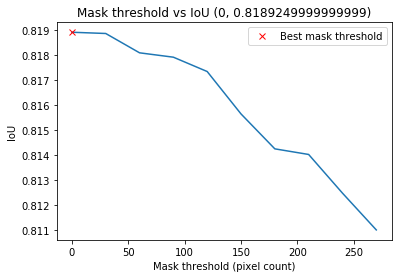

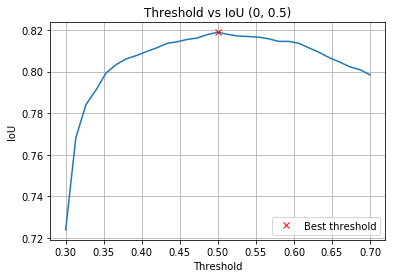

In [23]:
%run diagnostics.ipynb

In [24]:
test_preds = np.load(f'/home/radek/db/salt/test_preds_{name}.npy')

In [25]:
preds_to_sub(test_preds, db.test_dl.dl.dataset.x, 0.5, 0, name)

In [60]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f ../subs/{name}.csv.gz  -m {name}

Successfully submitted to TGS Salt Identification Challenge